# In-host dynamics of SARS-CoV-2
Based on two articles: 
* Within Host Dynamics of SARS‑CoV‑2 in Humans: Modeling Immune
Responses and Antiviral Treatments;
Indrajit Ghosh
* Modelling of the Innate and Adaptive Immune Response to
SARS Viral Infection, Cytokine Storm and Vaccination;
Cristina Leon, Alexey Tokarev, Anass Bouchnita and Vitaly Volpert

1. Start from simple **compatmental model** of virus-host cell dynamics
- H(t)=healthy uninfected cells
- V(t)=free virus
- I(t)=infected cells

Infected cells I produce virus particles V that leave the cell and find other susceptible target cells H.



In [44]:
# imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


A virus-clearance event was implemented uniformly across all models by terminating numerical integration when the viral load dropped below a fixed threshold.

Numerical integration was terminated once the viral load dropped below a clearance threshold 
V<10^−6
, reflecting effective elimination of the virus and preventing unnecessary computation in the post-clearance regime.

The viral load is negligible compared to biologically relevant levels.
* Below detection limit
* Immune clearance achieved
* No further biological impact

Although viral particles and cells are discrete entities, the model describes average concentrations and is formulated as a deterministic ODE system. Consequently, viral clearance is defined operationally by a small threshold value rather than an exact zero, corresponding to a viral load below biologically relevant or detectable levels. To have proper extinction we should have a stochastic model

In [45]:
def virus_clearance_event(t, y, *args):
    V = y[2]          # virus variable
    V_clear = 1e-5    # clearance threshold
    return V - V_clear

virus_clearance_event.terminal = True   # stop integration
virus_clearance_event.direction = -1    # only trigger when decreasing


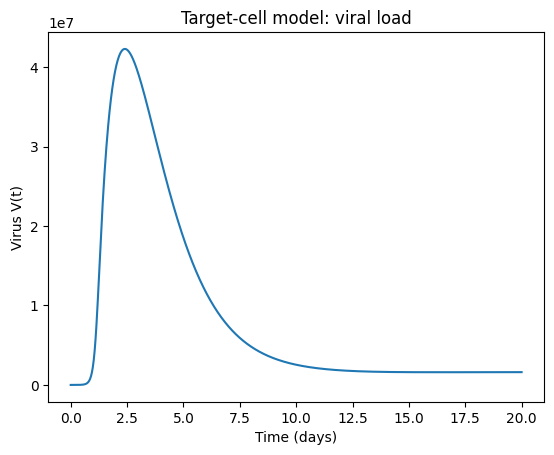

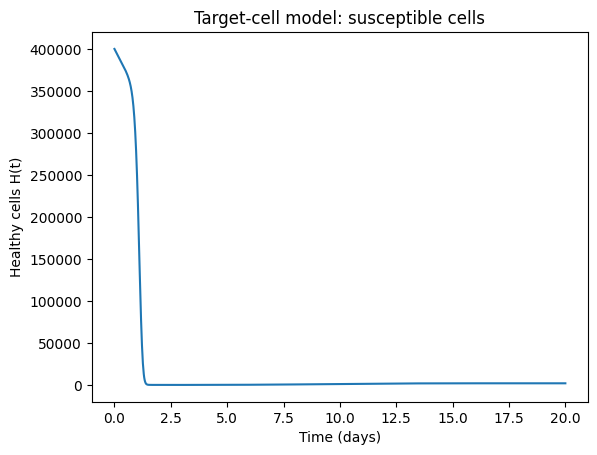

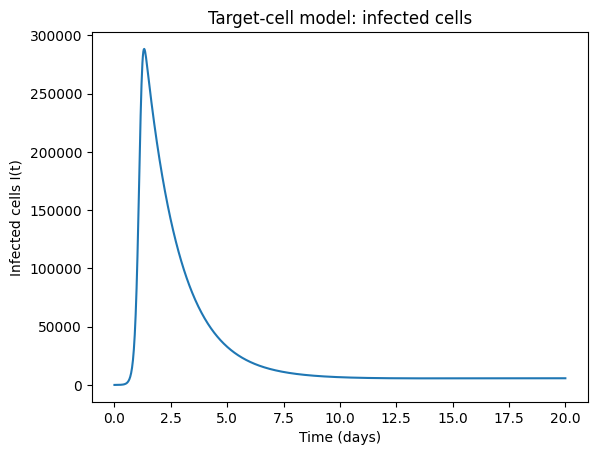

In [ ]:
# simple compartmental model
def target_cell_model(t, y, params):
    H, I, V = y 
    Pi, beta, mu1, mu2, mu3, k1 = params

    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - mu2 * I
    dVdt = k1 * I - mu3 * V

    return [dHdt, dIdt, dVdt]

params_tc = [
    4e3,        # Π (cells ml⁻¹ day⁻¹)
    1.1533e-6,  # beta  (ml RNA⁻¹ day⁻¹, mid-range)
    0.14,       # μ1 (day⁻¹)
    0.65,       # μ2 (day⁻¹)
    0.9004,     # mu3  
    253.5       # k1  (virions cell⁻¹ day⁻¹)
]

y0_tc = [4e5, 3e-4, 357]  # H, I, V
t_span = (0, 20)
t_eval = np.linspace(0, 20, 1000)

sol_tc = solve_ivp(
    target_cell_model, t_span, y0_tc,
    args=(params_tc,), t_eval=t_eval, 
    events=virus_clearance_event
)

plt.plot(sol_tc.t, sol_tc.y[2])
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.title("Target-cell model: viral load")
plt.show()

plt.plot(sol_tc.t, sol_tc.y[0])
plt.xlabel("Time (days)")
plt.ylabel("Healthy cells H(t)")
plt.title("Target-cell model: susceptible cells")
plt.show()

plt.plot(sol_tc.t, sol_tc.y[1])
plt.xlabel("Time (days)")
plt.ylabel("Infected cells I(t)")
plt.title("Target-cell model: infected cells")
plt.show()


2. Add innate immune response

Innate immune response works non-specifically and immediately. 
Cytokines C(t) inhibit viral replication. Specific cytokines activate Netural Killer cells N(t), which kill virus-infected cells.
IMMUNODEPRESSI!!!!


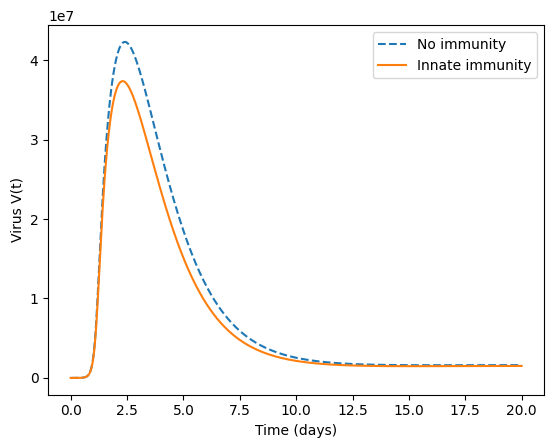

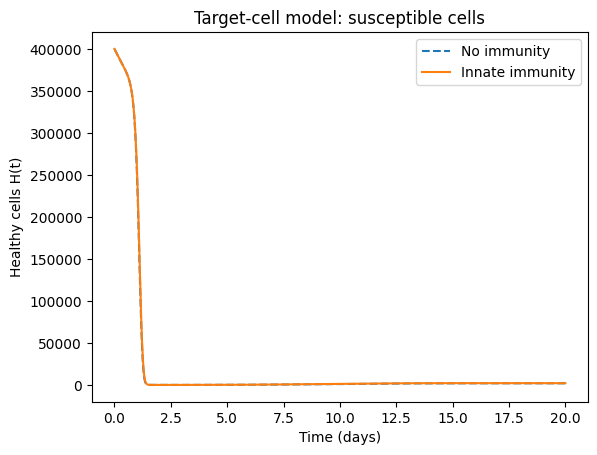

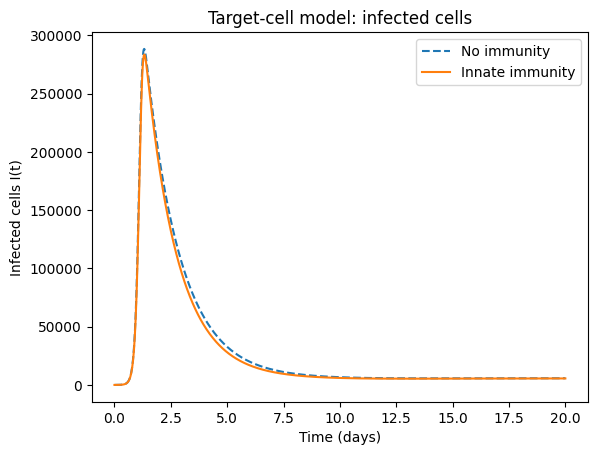

In [79]:
def innate_model(t, y, params):
    H, I, V, C, N = y
    Pi, beta, gamma, mu1, mu2, mu3, mu4, mu5, k1, k2, p2, p5, r = params

    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - p5 * N * I - mu2 * I
    dVdt = k1 * I - p2 * C * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N

    return [dHdt, dIdt, dVdt, dCdt, dNdt]

params_innate = [
    4e3,        # Π (production rate of healthy cells)
    1.1533e-6,  # β (rate healthy cells convert into infected cells)
    0.5,        # gamma (strength of immunosuppression)
    0.14,       # μ1 (death rate healthy cells)
    0.65,       # μ2 (death rate infected cells)
    0.9004,     # μ3 (clearance rate virus)
    0.7,        # μ4 (death rate cytokine)
    0.07,       # μ5 (death rate NK)
    253.5,      # k1 (production rate virus from infected cells)
    5.0,        # k2 (production rate of cytokines)
    0.6104,     # p2 (rate virus neutralized by cytokines)
    5.74e-4,    # p5 (rate infected cells killed by NK)
    0.52        # r (activation rate cytokines)
]

y0_innate = [4e5, 3e-4, 357, 0.0, 100.0]

sol_innate = solve_ivp(
    innate_model, t_span, y0_innate,
    args=(params_innate,), t_eval=t_eval,
    rtol=1e-5, atol=1e-8,
    events=virus_clearance_event
)


plt.plot(sol_tc.t, sol_tc.y[2], '--', label="No immunity")
plt.plot(sol_innate.t, sol_innate.y[2], label="Innate immunity")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()

plt.plot(sol_tc.t, sol_tc.y[0], '--', label="No immunity")
plt.plot(sol_innate.t, sol_innate.y[0], label="Innate immunity")
plt.xlabel("Time (days)")
plt.ylabel("Healthy cells H(t)")
plt.title("Target-cell model: susceptible cells")
plt.legend()
plt.show()

plt.plot(sol_tc.t, sol_tc.y[1], '--', label="No immunity")
plt.plot(sol_innate.t, sol_innate.y[1], label="Innate immunity")
plt.xlabel("Time (days)")
plt.ylabel("Infected cells I(t)")
plt.title("Target-cell model: infected cells")
plt.legend()
plt.show()


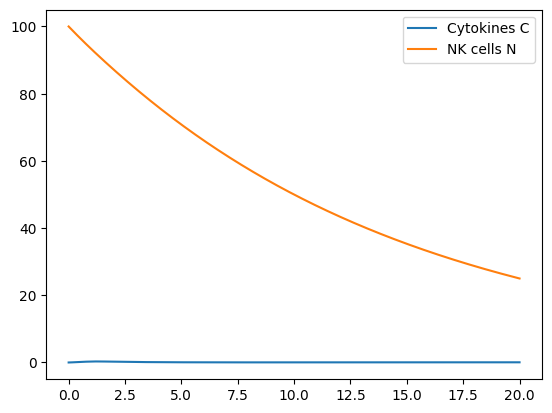

In [80]:
plt.plot(sol_innate.t, sol_innate.y[3], label="Cytokines C")
plt.plot(sol_innate.t, sol_innate.y[4], label="NK cells N")
plt.legend()
plt.show()


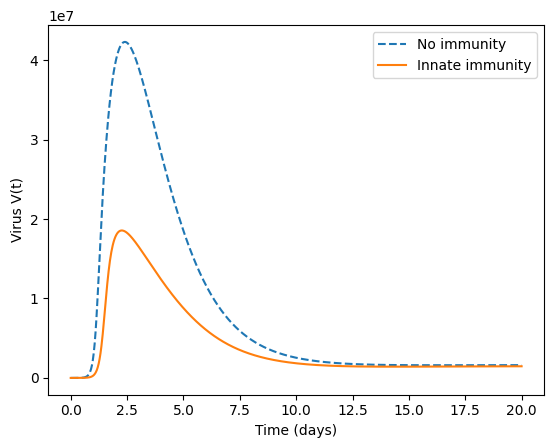

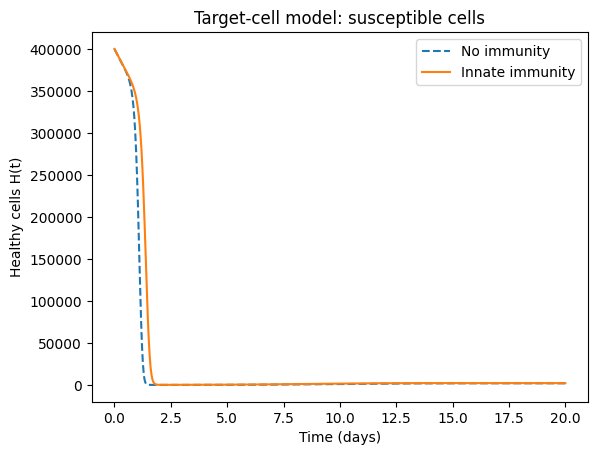

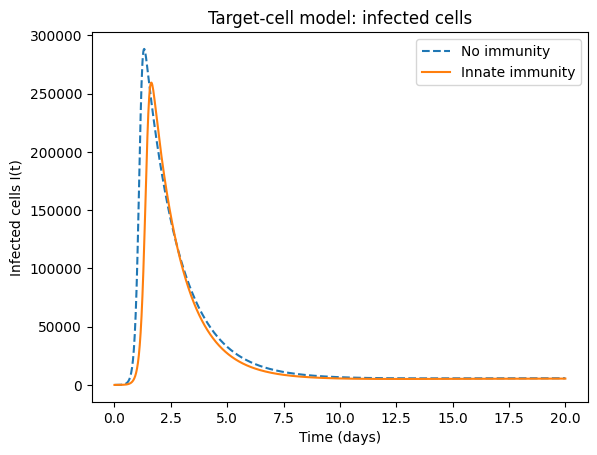

In [82]:
y0_innate1 = [4e5, 3e-4, 357, 10.0, 200.0]  # pre-activated innate immunity

sol_innate1 = solve_ivp(
    innate_model, t_span, y0_innate1,
    args=(params_innate,), t_eval=t_eval,
    rtol=1e-5, atol=1e-8,
    events=virus_clearance_event
)


plt.plot(sol_tc.t, sol_tc.y[2], '--', label="No immunity")
plt.plot(sol_innate1.t, sol_innate1.y[2], label="Innate immunity")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()

plt.plot(sol_tc.t, sol_tc.y[0], '--', label="No immunity")
plt.plot(sol_innate1.t, sol_innate1.y[0], label="Innate immunity")
plt.xlabel("Time (days)")
plt.ylabel("Healthy cells H(t)")
plt.title("Target-cell model: susceptible cells")
plt.legend()
plt.show()

plt.plot(sol_tc.t, sol_tc.y[1], '--', label="No immunity")
plt.plot(sol_innate1.t, sol_innate1.y[1], label="Innate immunity")
plt.xlabel("Time (days)")
plt.ylabel("Infected cells I(t)")
plt.title("Target-cell model: infected cells")
plt.legend()
plt.show()


3. Add adaptive immune response

Cytokines also activate the adaptive immune respponse, mainly T-lymphocytes T(t), which find virus infected cells and kill them. T-cells subsequently activate B-lympocytes B(t) to produce antibody A(t) against virus with the
aim of halting infection (and in future providing protection against a subsequent infection).


To prevent unbounded immune cell proliferation and ensure numerical stability, logistic saturation terms were introduced for T and B lymphocytes, reflecting physiological carrying capacities

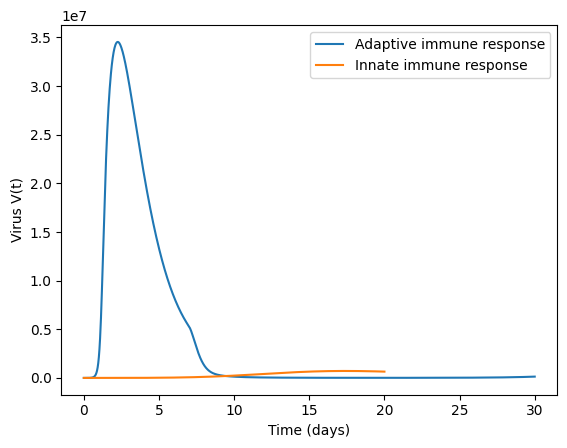

In [ ]:
def full_model(t, y, params):
    H, I, V, C, N, T, B, A = y
    (Pi, beta, gamma, 
    mu1, mu2, mu3, mu4, mu5, mu6, mu7, mu8, 
    k1, k2, p1, p2, p3, p4, p5, 
    r, lambda1, lambda2, eta, tau ) = params

    G = 1.0 if t >= tau else 0.0   # antibody delay
    
    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - p5 * N * I - p1 * T * I - mu2 * I
    dVdt = k1 * I - p2 * C * V - p3 * A * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N
    dTdt = lambda1 * C * T - mu6 * T
    dBdt = lambda2 * T * B - mu7 * B
    dAdt = G * eta * B - mu8 * A - p4 * A * V

    return [dHdt, dIdt, dVdt, dCdt, dNdt, dTdt, dBdt, dAdt]

params_full = [
    4e3,        # Pi
    1.1533e-6,       # beta  
    0.5,        # gamma
    0.14,       # mu1
    0.65,       # mu2  
    0.9004,     # mu3  
    0.7,        # mu4
    0.07,       # mu5
    1.0,        # mu6
    0.2,        # mu7
    0.07,       # mu8
    253.5,      # k1   
    5.0,        # k2   
    0.001,      # p1
    0.6104,     # p2   
    0.01865,       # p3   
    3e-7,       # p4   
    5.74e-4,    # p5
    0.52,       # r
    0.1,        # lambda1
    0.01,       # lambda2
    0.05,       # eta 
    7.0         # tau 
]

y0_immune = [
    4e5,  # H
    3e-4,  # I
    357, # V
    0.0,  # C
    100,  # N
    500,  # T
    100,  # B
    0.0   # A, no antibodies initially
]

t_span = (0, 30)
t_eval = np.linspace(0, 30, 1500)

sol_immune = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_full,), t_eval=t_eval, method="BDF",
    rtol=1e-6,
    atol=1e-9,
    events=virus_clearance_event
)

plt.plot(sol_immune.t, sol_immune.y[2], label="Adaptive immune response")
plt.plot(sol_innate.t, sol_innate.y[2], label="Innate immune response")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()


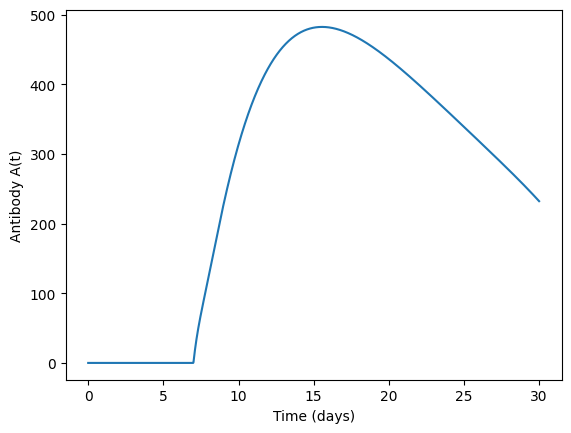

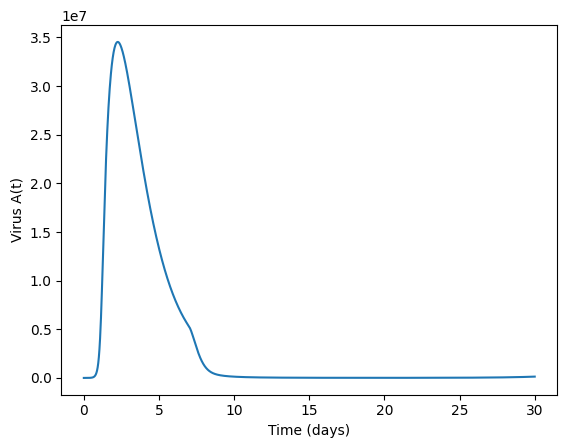

In [76]:
plt.plot(sol_immune.t, sol_immune.y[-1], label="Adaptive immune response")
plt.xlabel("Time (days)")
plt.ylabel("Antibody A(t)")
plt.show()

plt.plot(sol_immune.t, sol_immune.y[2], label="Adaptive immune response")
plt.xlabel("Time (days)")
plt.ylabel("Virus A(t)")
plt.show()



4. Add vaccination

A vaccine is a biological preparation that provides active acquired immunity to a particular
infectious agent. Thus if an individual is vaccinated, there
will be no delay in the development of antibody. For simplicity, assume that the person is vaccinated a sufficiently
large time ago so that the body develops antibodies against
SARS-CoV-2. Further, let me assume that the person is fully
vaccinated as most of the vaccines come with two doses.
Therefore, the delay term $\tau$ is taken to be zero for vaccinated individuals (see Fig. 7). It is observed that vaccination
not only reduces the viral load in healthy patients but also
reduces the duration of high viremia.

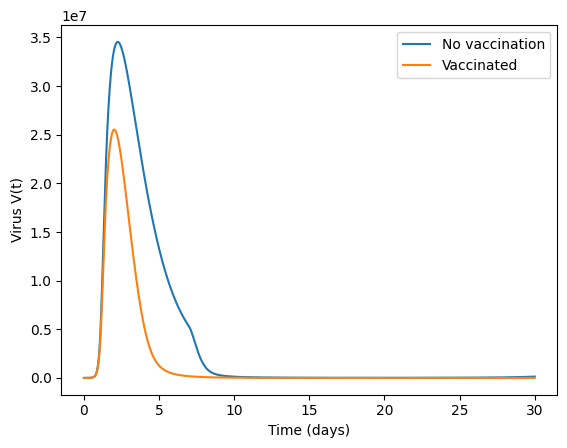

In [77]:

params_vaccine = params_full.copy()
params_vaccine[-1] = 0.0   # delete delay


sol_vaccine = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_vaccine,), t_eval=t_eval,
    events=virus_clearance_event
)

plt.plot(sol_immune.t, sol_immune.y[2], label="No vaccination")
plt.plot(sol_vaccine.t, sol_vaccine.y[2], label="Vaccinated")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()


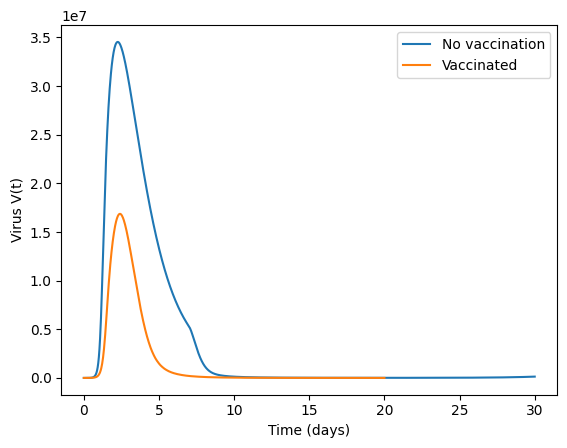

In [81]:
##version 2: altready antibody present
params_vaccine = params_full.copy()
params_vaccine[-1] = 0.0   # delete delay

y0_vaccine = [
    4e5,    # H
    3e-4,   # I
    357,    # V
    0.0,    # C
    100,    # N
    500,    # T
    100,    # B
    200.0   # A  <-- key change
]

sol_vaccine2 = solve_ivp(
    full_model, t_span, y0_vaccine,
    args=(params_vaccine,), t_eval=t_eval,
    events=virus_clearance_event
)

plt.plot(sol_immune.t, sol_immune.y[2], label="No vaccination")
plt.plot(sol_vaccine2.t, sol_vaccine2.y[2], label="Vaccinated")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()


5. Add antiviral drug

Antiviral drugs can be used to slow SARS-CoV-2 infection or block production of virus particles. These drugs
will necessarily save the lives of many severely ill patients
and will reduce the time spent in intensive care units for
patients, vacating hospital beds. Antiviral medications will,
in turn, inhibit subsequent transmission that could happen
if the drugs were not given. However, to analyze the effect
of antiviral treatment, we consider drugs can block infection
and/or production of virus particles. Many studies have suggested various existing compounds for testing [13, 47–49]
as SARS-CoV-2 antiviral drug. Recently, several drugs are
developed for moderate to severe COVID-19 patients and
some of them are in different phase of trial period. The 3rd
phase trial of [10] in India predicts that tocilizumab plus standard care in patients admitted to hospital with moderate
to severe COVID-19 has faster recovery and reduce the burden of intensive care. In addition, there are other drugs such
as Sotrovimab, Bamlanivimab and Etesevimab, Casirivimab
and Imdevimab which have shown significant efficacy and
are approved for emergency uses by US Food and Drug
Administration.
Following Zitzmann et al. [50], we incorporate antiviral drug treatment in the proposed model (1). The effect of
antiviral drugs can be either block infection (휖1) or block
production of viral particles (휖2). The newly infected term
훽HV now takes the form (1 − 휖1)훽HV and the production of
viral particles k1I becomes (1 − 휖2)k1I. Thus, the modified
system with antiviral treatment is given by

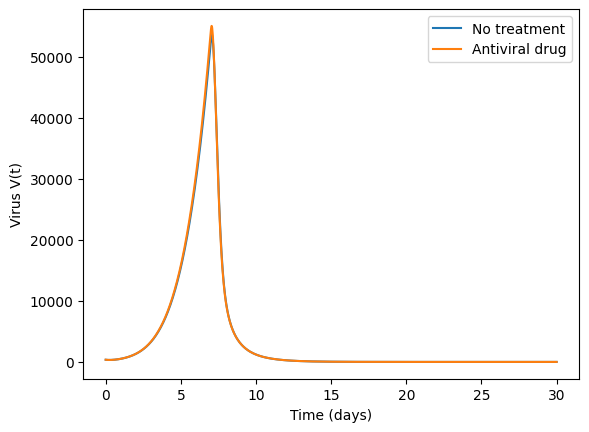

In [73]:
drug_efficacy = 0.01  # 80% efficacy

params_drug = params_full.copy()
params_drug[5] *= (1 - drug_efficacy)  # k → (1−ε)k

sol_drug = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_drug,), t_eval=t_eval,
    events=virus_clearance_event
)

plt.plot(sol_immune.t, sol_immune.y[2], label="No treatment")
plt.plot(sol_drug.t, sol_drug.y[2], label="Antiviral drug")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()


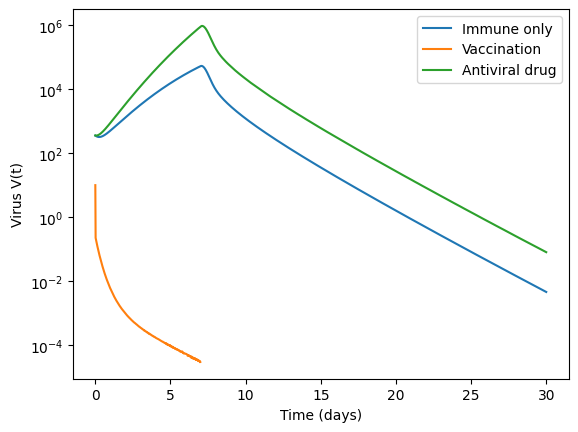

Peak V (immune only): 53573.1020828666
Peak V (vaccination): 10.0
Peak V (drug): 955174.175227969


In [64]:
plt.plot(sol_immune.t, sol_immune.y[2], label="Immune only")
plt.plot(sol_vaccine.t, sol_vaccine.y[2], label="Vaccination")
plt.plot(sol_drug.t, sol_drug.y[2], label="Antiviral drug")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()

def peak_viral_load(solution):
    return np.max(solution.y[2])

print("Peak V (immune only):", peak_viral_load(sol_immune))
print("Peak V (vaccination):", peak_viral_load(sol_vaccine))
print("Peak V (drug):", peak_viral_load(sol_drug))


se volessi calcolare R0: quante particelle virali escono da persona infetta (bottleneck) Kate Koelle
vacinazione come affect R0 ? stessa cosa per antivirali

I AM OBTAINING IMMUNE ONLY AND VACCINATION SAME RESULTS
DRUG TREATMENT RESULTS WORSE THAN ONLY IMMUNE

COMPUTE R0, PLOT I(final) vs R0, EPIDEMIC THRESHOLD

STUDY STABILITY AND STATIONARY PONTS

CHECK PARAMETERS FROM ARTICLE

MODEL A DOSE-RESPONSE VACCINATION

MODEL IMMUNOSUPPRESSED

Specific Extensions to Consider
- Antiviral treatment modeling: Ghosh mentions that "Antiviral drugs can be used to slow SARS-CoV-2 infection (or reduce β) or block the production of virus particles (or reduce k1)" [5]. You could model different treatment scenarios by modifying these parameters.

- Sensitivity analysis: Perform a global sensitivity analysis as mentioned in the paper to identify which parameters most strongly affect viral load.

- Variant modeling: Consider how the model parameters might change for different SARS-CoV-2 variants.

- Vaccination effects: Model how pre-existing antibodies from vaccination would affect the dynamics.

- Comparison with real data: The paper used data from two patients. You could try to fit the model to additional patient data if available.

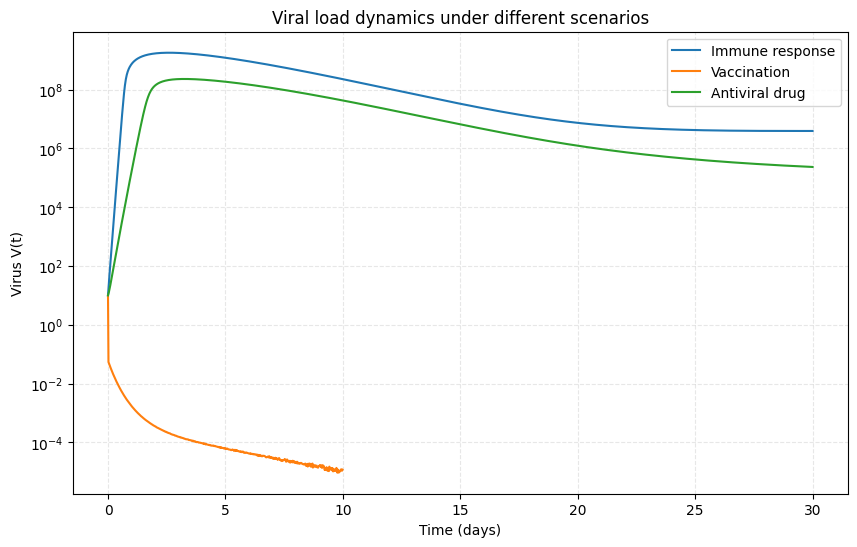

Peak V (immune only): 1784850726.3002539
Peak V (vaccination): 10.0
Peak V (drug): 228435577.32600626


In [ ]:
# imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def virus_clearance_event(t, y, *args):
    V = y[2]          # virus variable
    V_clear = 1e-5    # clearance threshold
    return V - V_clear

virus_clearance_event.terminal = True   # stop integration
virus_clearance_event.direction = -1    # only trigger when decreasing

# Simple target cell model (H, I, V)
def target_cell_model(t, y, params):
    H, I, V = y
    Pi, beta, mu1, mu2, mu3, k1 = params

    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - mu2 * I
    dVdt = k1 * I - mu3 * V

    return [dHdt, dIdt, dVdt]

# Using parameter values from the table in the image
params_tc = [
    4e3,        # Pi (cells ml⁻¹ day⁻¹)
    2e-7,       # beta (ml RNA⁻¹ day⁻¹, mid-range from 5e-9 to 5.61e-7)
    0.14,       # mu1 (day⁻¹)
    0.5,        # mu2 (day⁻¹, mid-range from 0-1)
    0.5,        # mu3 (day⁻¹, mid-range from 0-1)
    300.0       # k1 (day⁻¹, mid-range from 8.2-525)
]

y0_tc = [1e7, 1.0, 10.0]  # H, I, V
t_span = (0, 20)
t_eval = np.linspace(0, 20, 1000)

sol_tc = solve_ivp(
    target_cell_model, t_span, y0_tc,
    args=(params_tc,), t_eval=t_eval, 
    events=virus_clearance_event
)

# Innate immune response model (H, I, V, C, N)
def innate_model(t, y, params):
    H, I, V, C, N = y
    Pi, beta, mu1, mu2, mu3, k1, k2, gamma, p2, p5, mu4, mu5, r = params

    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - p5 * N * I - mu2 * I
    dVdt = k1 * I - p2 * C * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N

    return [dHdt, dIdt, dVdt, dCdt, dNdt]

params_innate = [
    4e3,        # Pi (cells ml⁻¹ day⁻¹)
    2e-7,       # beta (ml RNA⁻¹ day⁻¹)
    0.14,       # mu1 (day⁻¹)
    0.5,        # mu2 (day⁻¹)
    0.5,        # mu3 (day⁻¹)
    300.0,      # k1 (day⁻¹)
    5.0,        # k2 (day⁻¹, mid-range from 0-10)
    0.5,        # gamma (ml RNA copies⁻¹)
    0.5,        # p2 (ml cells⁻¹ day⁻¹, mid-range from 0-1)
    5.74e-4,    # p5 (ml cells⁻¹ day⁻¹)
    0.7,        # mu4 (day⁻¹)
    0.07,       # mu5 (day⁻¹)
    0.52        # r (day⁻¹)
]

y0_innate = [1e7, 1.0, 10.0, 0.0, 0.0]  # H, I, V, C, N

sol_innate = solve_ivp(
    innate_model, t_span, y0_innate,
    args=(params_innate,), t_eval=t_eval,
    rtol=1e-5, atol=1e-8,
    events=virus_clearance_event
)

# Full model with adaptive immune response (H, I, V, C, N, T, B, A)
def heaviside(t, tau):
    return 1.0 if t > tau else 0.0

def full_model(t, y, params):
    H, I, V, C, N, T, B, A = y
    (Pi, beta, mu1, mu2, mu3, k1, k2, gamma, 
     p1, p2, p3, p4, p5, 
     lambda1, lambda2, eta, tau,
     mu4, mu5, mu6, mu7, mu8, r) = params
    
    # Heaviside step function for antibody production delay
    G_t_tau = heaviside(t, tau)
    
    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - p1 * T * I - p5 * N * I - mu2 * I
    dVdt = k1 * I - p2 * C * V - p3 * A * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N
    dTdt = lambda1 * C * T - mu6 * T
    dBdt = lambda2 * T * B - mu7 * B
    dAdt = G_t_tau * eta * B - p4 * A * V - mu8 * A

    return [dHdt, dIdt, dVdt, dCdt, dNdt, dTdt, dBdt, dAdt]

# Parameters based on the table in the image
params_full = [
    4e3,        # Pi (cells ml⁻¹ day⁻¹)
    2e-7,       # beta (ml RNA⁻¹ day⁻¹)
    0.14,       # mu1 (day⁻¹)
    0.5,        # mu2 (day⁻¹)
    0.5,        # mu3 (day⁻¹)
    300.0,      # k1 (day⁻¹)
    5.0,        # k2 (day⁻¹)
    0.5,        # gamma (ml RNA copies⁻¹)
    
    0.001,      # p1 (ml cells⁻¹ day⁻¹)
    0.5,        # p2 (ml cells⁻¹ day⁻¹)
    0.5,        # p3 (ml molecules⁻¹ day⁻¹)
    3e-7,       # p4 (ml RNA copies⁻¹ day⁻¹)
    5.74e-4,    # p5 (ml cells⁻¹ day⁻¹)
    
    0.1,        # lambda1 (ml cells⁻¹ day⁻¹)
    0.01,       # lambda2 (ml cells⁻¹ day⁻¹)
    0.5,        # eta (day⁻¹)
    10.0,       # tau (days, mid-range from 7-14)
    
    0.7,        # mu4 (day⁻¹)
    0.07,       # mu5 (day⁻¹)
    1.0,        # mu6 (day⁻¹)
    0.2,        # mu7 (day⁻¹)
    0.07,       # mu8 (day⁻¹)
    0.52        # r (day⁻¹)
]

y0_immune = [
    1e7,  # H
    1.0,  # I
    10.0, # V
    0.0,  # C
    0.0,  # N
    1.0,  # T
    1.0,  # B
    0.0   # A
]

t_span = (0, 30)
t_eval = np.linspace(0, 30, 1500)

sol_immune = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_full,), t_eval=t_eval, method="BDF",
    rtol=1e-6,
    atol=1e-9,
    events=virus_clearance_event
)

# Vaccination scenario (pre-existing antibodies and memory cells)
y0_vaccine = [
    1e7,   # H
    1.0,   # I
    10.0,  # V
    0.0,   # C
    0.0,   # N
    5e3,   # T (memory)
    5e3,   # B (memory)
    1e4    # A (pre-existing antibodies)
]

params_vaccine = params_full.copy()
params_vaccine[9] = 0.8   # p3 ↑ (stronger antibody neutralization)
params_vaccine[15] = 0.8  # eta ↑ (faster Ab production)

sol_vaccine = solve_ivp(
    full_model, t_span, y0_vaccine,
    args=(params_vaccine,), t_eval=t_eval,
    events=virus_clearance_event
)

# Antiviral drug scenario (reduced viral production)
drug_efficacy = 0.8   # 80% efficacy

params_drug = params_full.copy()
params_drug[5] *= (1 - drug_efficacy)  # k1 → (1−ε)k1

sol_drug = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_drug,), t_eval=t_eval,
    events=virus_clearance_event
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sol_immune.t, sol_immune.y[2], label="Immune response")
plt.plot(sol_vaccine.t, sol_vaccine.y[2], label="Vaccination")
plt.plot(sol_drug.t, sol_drug.y[2], label="Antiviral drug")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.title("Viral load dynamics under different scenarios")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

def peak_viral_load(solution):
    return np.max(solution.y[2])

print("Peak V (immune only):", peak_viral_load(sol_immune))
print("Peak V (vaccination):", peak_viral_load(sol_vaccine))
print("Peak V (drug):", peak_viral_load(sol_drug))

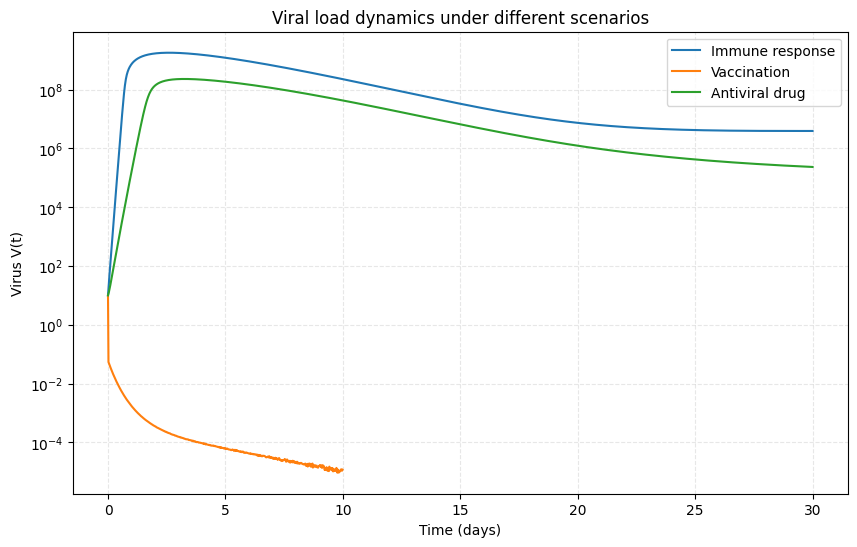

Peak V (immune only): 1784850726.3002539
Peak V (vaccination): 10.0
Peak V (drug): 228435577.32600626


In [ ]:
# imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def virus_clearance_event(t, y, *args):
    V = y[2]          # virus variable
    V_clear = 1e-5    # clearance threshold
    return V - V_clear

virus_clearance_event.terminal = True   # stop integration
virus_clearance_event.direction = -1    # only trigger when decreasing

# Simple target cell model (H, I, V)
def target_cell_model(t, y, params):
    H, I, V = y
    Pi, beta, mu1, mu2, mu3, k1 = params

    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - mu2 * I
    dVdt = k1 * I - mu3 * V

    return [dHdt, dIdt, dVdt]

# Using parameter values from the table in the image
params_tc = [
    4e3,        # Pi (cells ml⁻¹ day⁻¹)
    2e-7,       # beta (ml RNA⁻¹ day⁻¹, mid-range from 5e-9 to 5.61e-7)
    0.14,       # mu1 (day⁻¹)
    0.5,        # mu2 (day⁻¹, mid-range from 0-1)
    0.5,        # mu3 (day⁻¹, mid-range from 0-1)
    300.0       # k1 (day⁻¹, mid-range from 8.2-525)
]

y0_tc = [1e7, 1.0, 10.0]  # H, I, V
t_span = (0, 20)
t_eval = np.linspace(0, 20, 1000)

sol_tc = solve_ivp(
    target_cell_model, t_span, y0_tc,
    args=(params_tc,), t_eval=t_eval, 
    events=virus_clearance_event
)

# Innate immune response model (H, I, V, C, N)
def innate_model(t, y, params):
    H, I, V, C, N = y
    Pi, beta, mu1, mu2, mu3, k1, k2, gamma, p2, p5, mu4, mu5, r = params

    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - p5 * N * I - mu2 * I
    dVdt = k1 * I - p2 * C * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N

    return [dHdt, dIdt, dVdt, dCdt, dNdt]

params_innate = [
    4e3,        # Pi (cells ml⁻¹ day⁻¹)
    2e-7,       # beta (ml RNA⁻¹ day⁻¹)
    0.14,       # mu1 (day⁻¹)
    0.5,        # mu2 (day⁻¹)
    0.5,        # mu3 (day⁻¹)
    300.0,      # k1 (day⁻¹)
    5.0,        # k2 (day⁻¹, mid-range from 0-10)
    0.5,        # gamma (ml RNA copies⁻¹)
    0.5,        # p2 (ml cells⁻¹ day⁻¹, mid-range from 0-1)
    5.74e-4,    # p5 (ml cells⁻¹ day⁻¹)
    0.7,        # mu4 (day⁻¹)
    0.07,       # mu5 (day⁻¹)
    0.52        # r (day⁻¹)
]

y0_innate = [1e7, 1.0, 10.0, 0.0, 0.0]  # H, I, V, C, N

sol_innate = solve_ivp(
    innate_model, t_span, y0_innate,
    args=(params_innate,), t_eval=t_eval,
    rtol=1e-5, atol=1e-8,
    events=virus_clearance_event
)

# Full model with adaptive immune response (H, I, V, C, N, T, B, A)
def heaviside(t, tau):
    return 1.0 if t > tau else 0.0

def full_model(t, y, params):
    H, I, V, C, N, T, B, A = y
    (Pi, beta, mu1, mu2, mu3, k1, k2, gamma, 
     p1, p2, p3, p4, p5, 
     lambda1, lambda2, eta, tau,
     mu4, mu5, mu6, mu7, mu8, r) = params
    
    # Heaviside step function for antibody production delay
    G_t_tau = heaviside(t, tau)
    
    dHdt = Pi - beta * H * V - mu1 * H
    dIdt = beta * H * V - p1 * T * I - p5 * N * I - mu2 * I
    dVdt = k1 * I - p2 * C * V - p3 * A * V - mu3 * V
    dCdt = k2 * I / (1 + gamma * V) - mu4 * C
    dNdt = r * C - mu5 * N
    dTdt = lambda1 * C * T - mu6 * T
    dBdt = lambda2 * T * B - mu7 * B
    dAdt = G_t_tau * eta * B - p4 * A * V - mu8 * A

    return [dHdt, dIdt, dVdt, dCdt, dNdt, dTdt, dBdt, dAdt]

# Parameters based on the table in the image
params_full = [
    4e3,        # Pi (cells ml⁻¹ day⁻¹)
    2e-7,       # beta (ml RNA⁻¹ day⁻¹)
    0.14,       # mu1 (day⁻¹)
    0.5,        # mu2 (day⁻¹)
    0.5,        # mu3 (day⁻¹)
    300.0,      # k1 (day⁻¹)
    5.0,        # k2 (day⁻¹)
    0.5,        # gamma (ml RNA copies⁻¹)
    
    0.001,      # p1 (ml cells⁻¹ day⁻¹)
    0.5,        # p2 (ml cells⁻¹ day⁻¹)
    0.5,        # p3 (ml molecules⁻¹ day⁻¹)
    3e-7,       # p4 (ml RNA copies⁻¹ day⁻¹)
    5.74e-4,    # p5 (ml cells⁻¹ day⁻¹)
    
    0.1,        # lambda1 (ml cells⁻¹ day⁻¹)
    0.01,       # lambda2 (ml cells⁻¹ day⁻¹)
    0.5,        # eta (day⁻¹)
    10.0,       # tau (days, mid-range from 7-14)
    
    0.7,        # mu4 (day⁻¹)
    0.07,       # mu5 (day⁻¹)
    1.0,        # mu6 (day⁻¹)
    0.2,        # mu7 (day⁻¹)
    0.07,       # mu8 (day⁻¹)
    0.52        # r (day⁻¹)
]

y0_immune = [
    1e7,  # H
    1.0,  # I
    10.0, # V
    0.0,  # C
    0.0,  # N
    1.0,  # T
    1.0,  # B
    0.0   # A
]

t_span = (0, 30)
t_eval = np.linspace(0, 30, 1500)

sol_immune = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_full,), t_eval=t_eval, method="BDF",
    rtol=1e-6,
    atol=1e-9,
    events=virus_clearance_event
)

# Vaccination scenario (pre-existing antibodies and memory cells)
y0_vaccine = [
    1e7,   # H
    1.0,   # I
    10.0,  # V
    0.0,   # C
    0.0,   # N
    5e3,   # T (memory)
    5e3,   # B (memory)
    1e4    # A (pre-existing antibodies)
]

params_vaccine = params_full.copy()
params_vaccine[9] = 0.8   # p3 ↑ (stronger antibody neutralization)
params_vaccine[15] = 0.8  # eta ↑ (faster Ab production)

sol_vaccine = solve_ivp(
    full_model, t_span, y0_vaccine,
    args=(params_vaccine,), t_eval=t_eval,
    events=virus_clearance_event
)

# Antiviral drug scenario (reduced viral production)
drug_efficacy = 0.8   # 80% efficacy

params_drug = params_full.copy()
params_drug[5] *= (1 - drug_efficacy)  # k1 → (1−ε)k1

sol_drug = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_drug,), t_eval=t_eval,
    events=virus_clearance_event
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sol_immune.t, sol_immune.y[2], label="Immune response")
plt.plot(sol_vaccine.t, sol_vaccine.y[2], label="Vaccination")
plt.plot(sol_drug.t, sol_drug.y[2], label="Antiviral drug")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.title("Viral load dynamics under different scenarios")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

def peak_viral_load(solution):
    return np.max(solution.y[2])

print("Peak V (immune only):", peak_viral_load(sol_immune))
print("Peak V (vaccination):", peak_viral_load(sol_vaccine))
print("Peak V (drug):", peak_viral_load(sol_drug))